In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Стилизация графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [2]:
# Загрузка данных
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

print(f"Размеры данных до обработки:")
print(f"Тренировочные данные: {train.shape}")
print(f"Тестовые данные: {test.shape}")

# Очистка целевой переменной
train = train[~train['RiskScore'].isna()]
train = train[train['RiskScore'].between(0, 100)]

print(f"\nТренировочные данные после очистки: {train.shape}")

# Статистика целевой переменной
print("Статистика RiskScore:")
print(train['RiskScore'].describe())

Размеры данных до обработки:
Тренировочные данные: (11017, 35)
Тестовые данные: (5000, 35)

Тренировочные данные после очистки: (10272, 35)
Статистика RiskScore:
count    10272.000000
mean        48.358094
std         17.241456
min         14.841417
25%         32.722756
50%         44.195792
75%         65.124190
max         97.597249
Name: RiskScore, dtype: float64


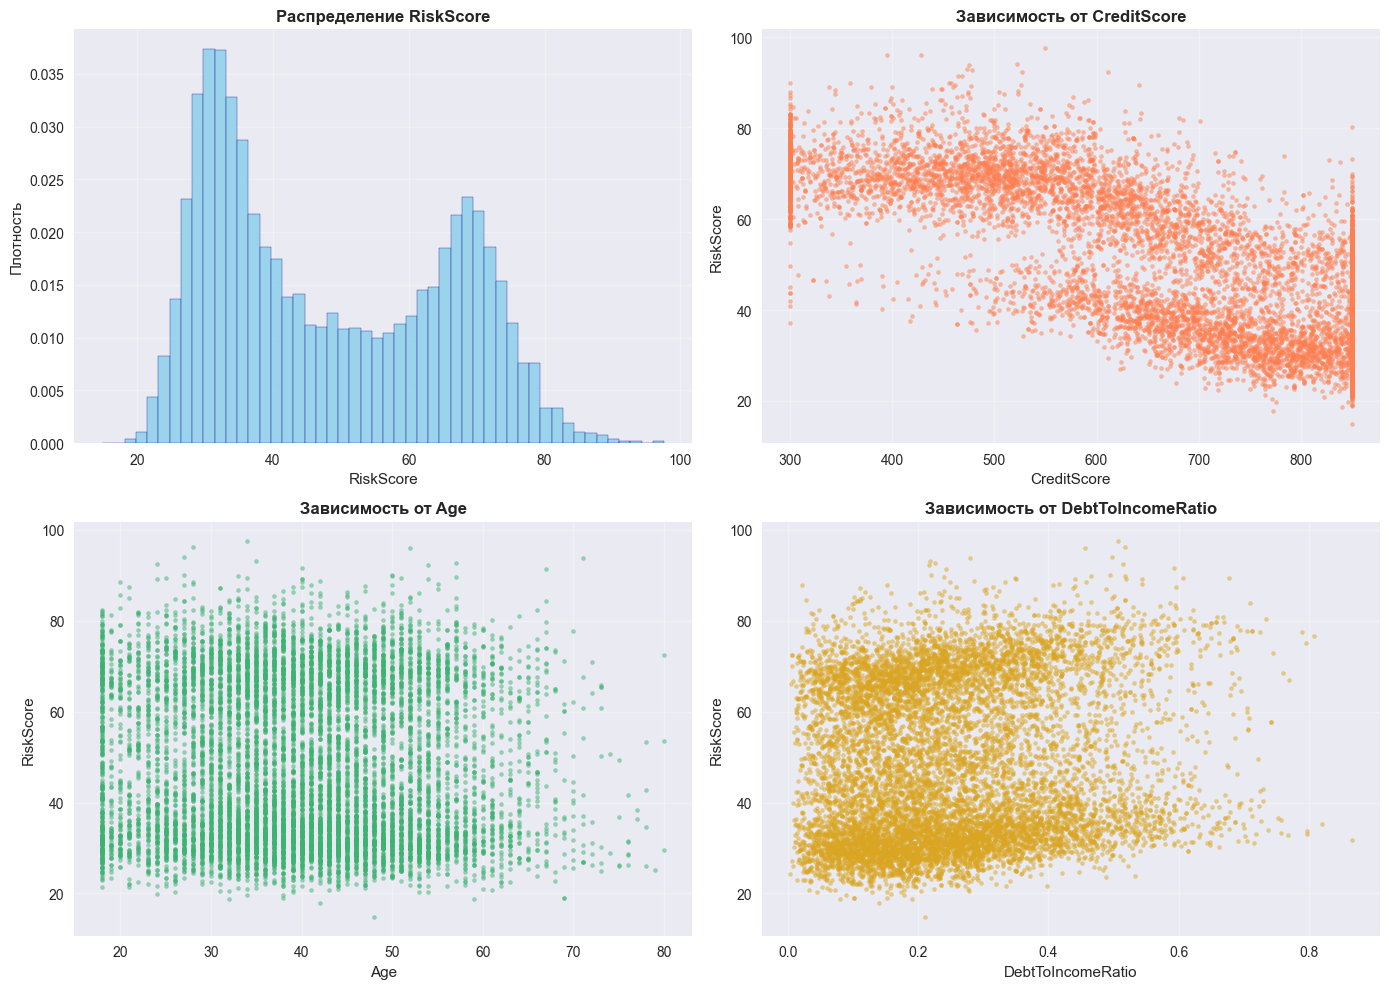

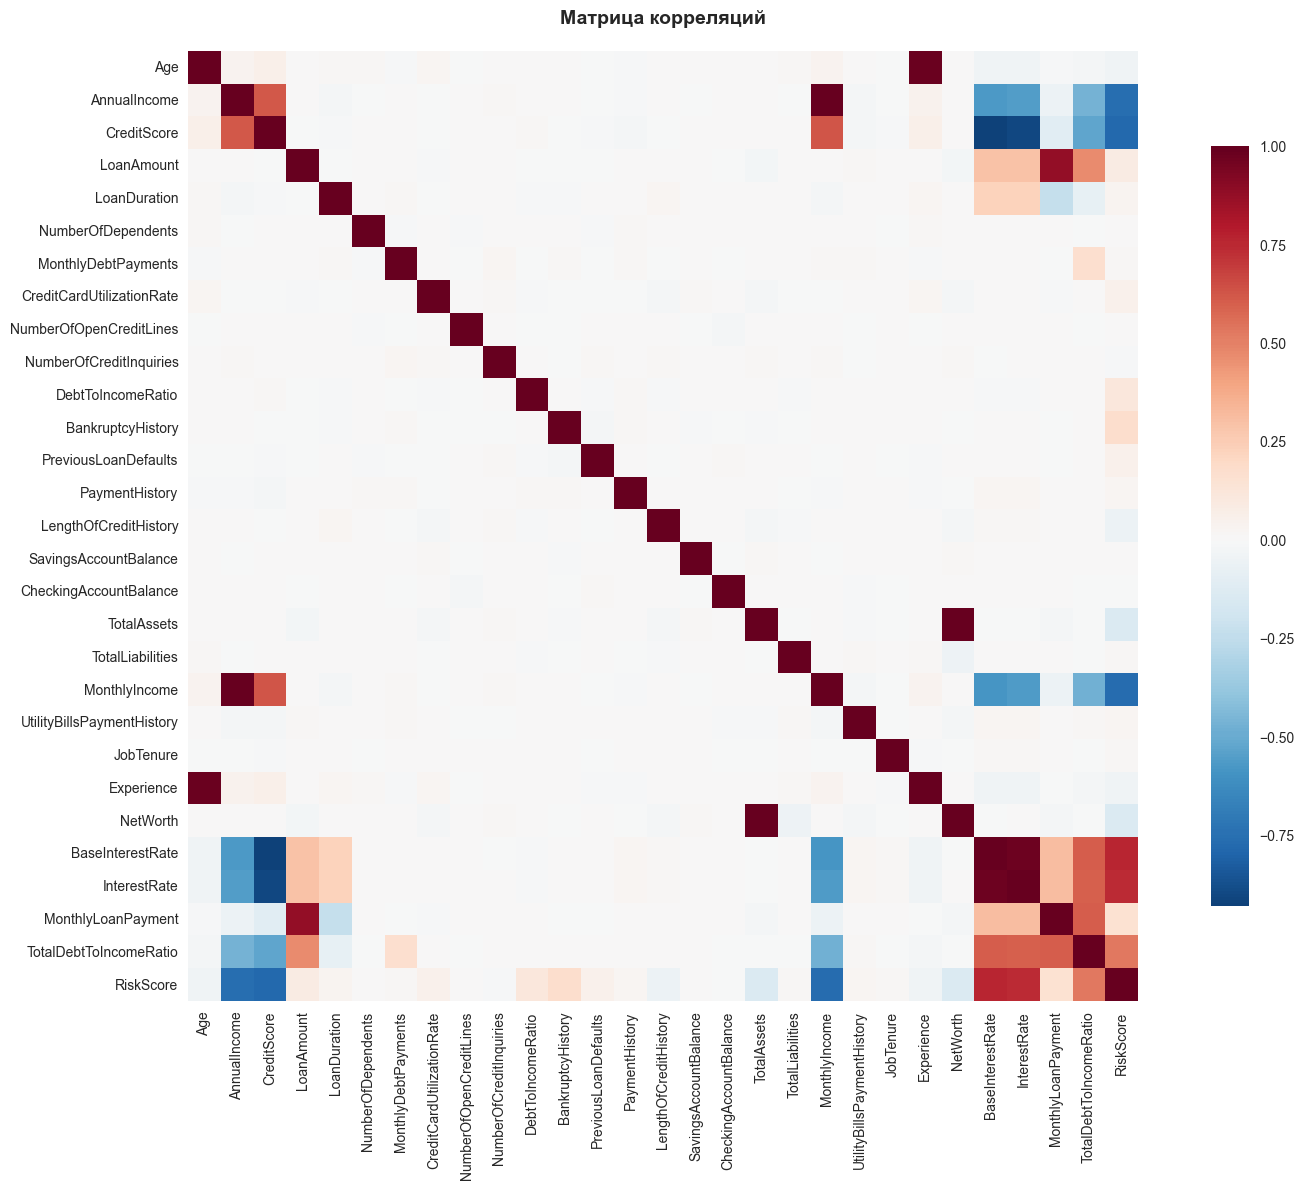


Топ-10 признаков по корреляции с RiskScore:
 1. RiskScore                      : 1.0000
 2. BaseInterestRate               : 0.7587
 3. InterestRate                   : 0.7426
 4. TotalDebtToIncomeRatio         : 0.5307
 5. BankruptcyHistory              : 0.1776
 6. MonthlyLoanPayment             : 0.1508
 7. DebtToIncomeRatio              : 0.1109
 8. LoanAmount                     : 0.0850
 9. CreditCardUtilizationRate      : 0.0561
10. PreviousLoanDefaults           : 0.0550
11. LoanDuration                   : 0.0283


In [3]:
# Визуализация распределений
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].hist(train['RiskScore'], bins=50, color='skyblue',
               edgecolor='navy', alpha=0.8, density=True)
axes[0,0].set_title('Распределение RiskScore', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('RiskScore')
axes[0,0].set_ylabel('Плотность')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].scatter(train['CreditScore'], train['RiskScore'],
                  alpha=0.5, s=8, color='coral')
axes[0,1].set_title('Зависимость от CreditScore', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('CreditScore')
axes[0,1].set_ylabel('RiskScore')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].scatter(train['Age'], train['RiskScore'],
                  alpha=0.5, s=8, color='mediumseagreen')
axes[1,0].set_title('Зависимость от Age', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('RiskScore')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(train['DebtToIncomeRatio'], train['RiskScore'],
                  alpha=0.5, s=8, color='goldenrod')
axes[1,1].set_title('Зависимость от DebtToIncomeRatio', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('DebtToIncomeRatio')
axes[1,1].set_ylabel('RiskScore')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Матрица корреляций
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='RdBu_r', center=0,
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Топ коррелирующих признаков
print("\nТоп-10 признаков по корреляции с RiskScore:")
risk_corr = correlation_matrix['RiskScore'].sort_values(ascending=False)
for idx, (feature, corr) in enumerate(risk_corr.head(11).items(), 1):
    print(f"{idx:2}. {feature:30} : {corr:.4f}")



In [4]:
def extract_date_features(df, col='ApplicationDate'):
    """Извлечение признаков из даты"""
    if col not in df.columns:
        return df

    dates = pd.to_datetime(df[col], errors='coerce')
    fallback_date = dates.mode()[0] if not dates.mode().empty else dates.min()
    dates = dates.fillna(fallback_date)

    new_features = {
        f'{col}_Year': dates.dt.year,
        f'{col}_Month': dates.dt.month,
        f'{col}_Quarter': dates.dt.quarter,
        f'{col}_Week': dates.dt.isocalendar().week.astype(float)
    }

    day_of_week = dates.dt.dayofweek
    angle = 2 * np.pi * day_of_week / 7.0
    new_features[f'{col}_DayOfWeek_Sin'] = np.sin(angle)
    new_features[f'{col}_DayOfWeek_Cos'] = np.cos(angle)

    return df.assign(**new_features).drop(columns=[col])


def add_binning_features(df):
    """Создание бинированных признаков"""
    bins_config = {
        'CreditScore': [300, 580, 620, 660, 700, 740, 780, 820, 900],
        'AnnualIncome': [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf],
        'TotalDebtToIncomeRatio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf],
        'InterestRate': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf],
        'Age': [18, 30, 45, 60, np.inf],
        'LoanAmount': [0, 30000, 60000, 100000, np.inf],
    }

    binned_features = []

    for col, bins in bins_config.items():
        if col not in df.columns:
            continue

        binned = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
        dummies = pd.get_dummies(binned, prefix=f"Bin_{col}", drop_first=True, dtype=int)
        binned_features.append(dummies)

    if binned_features:
        return pd.concat([df] + binned_features, axis=1)
    return df


def preprocess_advanced(df, is_train=True, stats=None):
    """Основная функция предобработки данных"""
    EPS = 1e-5
    df = df.copy()
    quantiles = stats if stats is not None else {}

    # Кодирование образования
    if 'EducationLevel' in df.columns:
        education_mapping = {
            'High School': 1,
            'Associate': 2,
            'Bachelor': 3,
            'Master': 4,
            'Doctorate': 5
        }
        df['EducationLevel'] = df['EducationLevel'].map(education_mapping).fillna(0).astype(int)

    # One-hot кодирование категориальных признаков
    nominal_cols = ['HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus']
    cols_to_encode = [c for c in nominal_cols if c in df.columns]
    if cols_to_encode:
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)

    # Извлечение признаков из даты
    df = extract_date_features(df, 'ApplicationDate')

    # Заполнение пропусков
    df = df.fillna(df.median(numeric_only=True))

    # Создание новых признаков
    if 'InterestRate' in df.columns and 'BaseInterestRate' in df.columns:
        df['InterestRateSpread'] = df['InterestRate'] - df['BaseInterestRate']

    if 'AnnualIncome' in df.columns:
        if 'LoanAmount' in df.columns:
            df['LoanToIncome'] = df['LoanAmount'] / (df['AnnualIncome'] + EPS)
        if 'NetWorth' in df.columns:
            df['NetWorthToIncome'] = df['NetWorth'] / (df['AnnualIncome'] + EPS)
        if 'NumberOfDependents' in df.columns:
            df['IncomePerDependent'] = df['AnnualIncome'] / (df['NumberOfDependents'] + 1)
        if 'MonthlyIncome' in df.columns:
            df['IncomeDiscrepancy'] = df['AnnualIncome'] - (df['MonthlyIncome'] * 12.0)

    if all(col in df.columns for col in ['MonthlyIncome', 'MonthlyLoanPayment', 'MonthlyDebtPayments']):
        total_debt = df['MonthlyLoanPayment'] + df['MonthlyDebtPayments']
        disposable = df['MonthlyIncome'] - total_debt
        df['DebtServiceRatio'] = total_debt / (df['MonthlyIncome'] + EPS)
        df['DisposableIncome'] = disposable
        df['Stress_Loan_Payment_Ratio'] = df['MonthlyLoanPayment'] / disposable.replace(0, EPS)

    if 'TotalAssets' in df.columns and 'TotalLiabilities' in df.columns:
        df['LiabilityGap'] = df['TotalLiabilities'] - df['TotalAssets']
        df['AssetCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + EPS)
        if 'NetWorth' in df.columns:
            df['NetWorthToLiabilities'] = df['NetWorth'] / (df['TotalLiabilities'] + EPS)

    if 'NumberOfOpenCreditLines' in df.columns:
        num_lines = df['NumberOfOpenCreditLines'] + 1
        if 'CreditCardUtilizationRate' in df.columns:
            df['UtilizationPerLine'] = df['CreditCardUtilizationRate'] / num_lines
        if 'NumberOfCreditInquiries' in df.columns:
            df['InquiryPerLine'] = df['NumberOfCreditInquiries'] / num_lines
        if 'TotalLiabilities' in df.columns:
            df['Avg_Debt_Per_Line'] = df['TotalLiabilities'] / num_lines

    if 'Age' in df.columns:
        if 'LengthOfCreditHistory' in df.columns:
            df['CreditHistoryToAge'] = df['LengthOfCreditHistory'] / (df['Age'] + EPS)
        if 'Experience' in df.columns:
            df['ExperienceToAge'] = df['Experience'] / (df['Age'] + EPS)

    # Логарифмическое преобразование
    cols_to_log = [
        'AnnualIncome', 'MonthlyLoanPayment', 'MonthlyDebtPayments',
        'TotalAssets', 'TotalLiabilities', 'LoanAmount', 'NetWorth',
        'IncomePerDependent', 'IncomeDiscrepancy', 'DisposableIncome',
        'LiabilityGap', 'Avg_Debt_Per_Line'
    ]

    for col in cols_to_log:
        if col in df.columns:
            df[col] = np.sign(df[col]) * np.log1p(np.abs(df[col]))

    # Добавление бинированных признаков
    df = add_binning_features(df)

    # Обрезка выбросов
    clip_cols = [
        'DebtServiceRatio', 'InquiryPerLine', 'Stress_Loan_Payment_Ratio',
        'AssetCoverage', 'NetWorthToLiabilities', 'UtilizationPerLine',
        'CreditHistoryToAge', 'LoanToIncome', 'DisposableIncome', 'LiabilityGap'
    ]

    if is_train:
        for col in clip_cols:
            if col in df.columns:
                quantiles[col] = df[col].quantile(0.55)

    for col in clip_cols:
        if col in df.columns and col in quantiles:
            threshold = quantiles[col]
            df[f'HighFlag_{col}'] = (df[col] > threshold).astype(int)
            df[col] = df[col].clip(upper=threshold)

    # Удаление ненужных столбцов
    drop_cols = ['ID', 'MaritalStatus', 'BaseInterestRate']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    return df, quantiles

In [5]:
# Применение предобработки
y = train['RiskScore']
X = train.drop(columns=['RiskScore'])
X_test_raw = test.copy()

X, stats = preprocess_advanced(X, is_train=True)
X_test_raw, _ = preprocess_advanced(X_test_raw, is_train=False, stats=stats)

# Выравнивание столбцов
train_cols = X.columns.tolist()
for col in train_cols:
    if col not in X_test_raw.columns:
        X_test_raw[col] = 0
X_test_raw = X_test_raw[train_cols]

print(f"Размерности после предобработки:")
print(f"X_train: {X.shape}")
print(f"X_test:  {X_test_raw.shape}")

Размерности после предобработки:
X_train: (10272, 92)
X_test:  (5000, 92)


In [6]:
class DataNormalizer:
    """Класс для нормализации данных"""

    def __init__(self, method='zscore'):
        self.method = method
        self.params = {}

    def fit(self, X):
        if self.method == 'zscore':
            self.params['mean'] = np.mean(X, axis=0)
            self.params['std'] = np.std(X, axis=0)
            self.params['std'][self.params['std'] < 1e-9] = 1.0
        elif self.method == 'minmax':
            self.params['min'] = np.min(X, axis=0)
            self.params['max'] = np.max(X, axis=0)
            range_val = self.params['max'] - self.params['min']
            range_val[range_val < 1e-9] = 1.0
            self.params['range'] = range_val
        return self

    def transform(self, X):
        if self.method == 'zscore':
            return (X - self.params['mean']) / self.params['std']
        elif self.method == 'minmax':
            return (X - self.params['min']) / self.params['range']

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        if self.method == 'zscore':
            return X_scaled * self.params['std'] + self.params['mean']
        elif self.method == 'minmax':
            return X_scaled * self.params['range'] + self.params['min']


class MyLinearRegression:
    """Кастомная реализация линейной регрессии"""

    def __init__(self, method='analytic', alpha=0.01, learning_rate=0.01,
                 n_iterations=1000, batch_size=32, random_state=42):
        self.method = method
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)
        n_samples, n_features = X.shape

        if self.method == 'analytic':
            X_b = np.c_[np.ones((n_samples, 1)), X]
            I = np.eye(n_features + 1)
            I[0, 0] = 0

            XtX = X_b.T @ X_b
            XtX_reg = XtX + (self.alpha * I)
            theta = np.linalg.pinv(XtX_reg) @ X_b.T @ y

            self.bias = theta[0]
            self.weights = theta[1:]

        elif self.method == 'gradient':
            self.weights = np.zeros(n_features)
            self.bias = 0

            for i in range(self.n_iterations):
                predictions = X @ self.weights + self.bias
                errors = predictions - y

                gradient_w = (1 / n_samples) * X.T @ errors + self.alpha * self.weights
                gradient_b = (1 / n_samples) * np.sum(errors)

                self.weights -= self.learning_rate * gradient_w
                self.bias -= self.learning_rate * gradient_b

        elif self.method == 'sgd':
            np.random.seed(self.random_state)
            self.weights = np.zeros(n_features)
            self.bias = 0

            for epoch in range(self.n_iterations):
                indices = np.random.permutation(n_samples)
                for start in range(0, n_samples, self.batch_size):
                    end = min(start + self.batch_size, n_samples)
                    X_batch = X[indices[start:end]]
                    y_batch = y[indices[start:end]]

                    predictions = X_batch @ self.weights + self.bias
                    errors = predictions - y_batch
                    bs = len(X_batch)

                    gradient_w = (1 / bs) * X_batch.T @ errors + self.alpha * self.weights
                    gradient_b = (1 / bs) * np.sum(errors)

                    self.weights -= self.learning_rate * gradient_w
                    self.bias -= self.learning_rate * gradient_b

        return self

    def predict(self, X):
        return np.array(X, dtype=float) @ self.weights + self.bias


In [7]:
def my_mse(y_true, y_pred):
    """Среднеквадратичная ошибка"""
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

def my_mae(y_true, y_pred):
    """Средняя абсолютная ошибка"""
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

def my_r2(y_true, y_pred):
    """Коэффициент детерминации R²"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot < 1e-9:
        return 0.0
    return 1 - (ss_res / ss_tot)

def my_mape(y_true, y_pred):
    """Средняя абсолютная процентная ошибка"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-8
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)))

In [8]:
# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(X.values, y.values,
                                                   test_size=0.2, random_state=42)

# Нормализация
normalizer = DataNormalizer('zscore')
X_train_norm = normalizer.fit_transform(X_train)
X_val_norm = normalizer.transform(X_val)

print("Сравнение методов линейной регрессии:\n")

methods = [
    ('Аналитический метод', 'analytic', 10, {'alpha': 10}),
    ('Градиентный спуск', 'gradient', 10, {'alpha': 10, 'learning_rate': 0.01, 'n_iterations': 1000}),
    ('SGD', 'sgd', 10, {'alpha': 10, 'learning_rate': 0.01, 'n_iterations': 100, 'batch_size': 64}),
]

for name, method, _, params in methods:
    model = MyLinearRegression(method=method, **params)
    model.fit(X_train_norm, y_train)
    mse = mean_squared_error(y_val, model.predict(X_val_norm))
    print(f"{name:25} MSE: {mse:.4f}")

# Sklearn модель
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_norm, y_train)
sklearn_mse = mean_squared_error(y_val, sklearn_model.predict(X_val_norm))
print(f"{'Sklearn':25} MSE: {sklearn_mse:.4f}")

y_pred_test = sklearn_model.predict(X_val_norm)


Сравнение методов линейной регрессии:

Аналитический метод       MSE: 28.4268
Градиентный спуск         MSE: 113.9906
SGD                       MSE: 116.7351
Sklearn                   MSE: 28.4450


In [9]:
def k_fold_cv(X, y, model, k=5):
    """K-Fold кросс-валидация"""
    n = len(X)
    fold_size = n // k
    indices = np.arange(n)
    np.random.shuffle(indices)
    scores = []

    for i in range(k):
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        val_idx = indices[val_start:val_end]
        train_idx = np.concatenate([indices[:val_start], indices[val_end:]])

        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        scores.append(my_mse(y[val_idx], y_pred))

    return np.mean(scores), np.std(scores)


def loo_cv(X, y, model, max_samples=200):
    """Leave-One-Out кросс-валидация"""
    n = min(len(X), max_samples)
    scores = []

    for i in range(n):
        X_train = np.concatenate([X[:i], X[i + 1:n]])
        y_train = np.concatenate([y[:i], y[i + 1:n]])
        model.fit(X_train, y_train)
        y_pred = model.predict(X[i:i + 1])
        scores.append(my_mse(y[i:i + 1], y_pred))

    return np.mean(scores), np.std(scores)


In [10]:
print("K-Fold кросс-валидация (k=5):")
model_cv = MyLinearRegression('analytic', alpha=10)
mean_mse_cv, std_mse = k_fold_cv(X_train_norm[:1000], y_train[:1000], model_cv, k=5)
print(f"Средний MSE: {mean_mse_cv:.4f} ± {std_mse:.4f}")

print("\nLeave-One-Out кросс-валидация (200 сэмплов):")
model_loo = MyLinearRegression('analytic', alpha=10)
mean_mse_loo, std_mse_loo = loo_cv(X_train_norm[:200], y_train[:200], model_loo, max_samples=200)
print(f"Средний MSE: {mean_mse_loo:.4f} ± {std_mse_loo:.4f}")


K-Fold кросс-валидация (k=5):
Средний MSE: 33.0476 ± 5.5182

Leave-One-Out кросс-валидация (200 сэмплов):
Средний MSE: 30.6407 ± 51.9753


In [11]:
def create_smart_polynomials(X, poly_cols_indices):
    """Создание полиномиальных признаков"""
    X_base = X.copy()
    X_poly = X[:, poly_cols_indices]

    squared = np.power(X_poly, 2)
    sqrt_transformed = np.sqrt(np.abs(X_poly) + 1e-3)

    from itertools import combinations
    max_cols = min(X_poly.shape[1], 20)
    interaction_pairs = combinations(range(max_cols), 2)
    interactions = np.column_stack([
        X_poly[:, i] * X_poly[:, j]
        for i, j in interaction_pairs
    ]) if max_cols > 1 else np.empty((X_poly.shape[0], 0))

    return np.hstack([X_base, squared, sqrt_transformed, interactions])


# Выбор признаков для полиномов
X_full = X.values
y_full = y.values

not_binary = [
    i for i, col in enumerate(train_cols)
    if not (col.startswith('Bin_') or col.startswith('HighFlag_') or
            '_Sin' in col or '_Cos' in col or col.startswith('Is_'))
]

corrs = []
for i in not_binary:
    c = np.corrcoef(X_full[:, i], y_full)[0, 1]
    if not np.isnan(c):
        corrs.append((i, abs(c)))

corrs.sort(key=lambda x: x[1], reverse=True)
top_poly_indices = [x[0] for x in corrs[:15]]
print(f"Топ-5 признаков для полиномов: {[train_cols[i] for i in top_poly_indices[:5]]}")

# Создание полиномиальных признаков
X_full_poly = create_smart_polynomials(X_full, top_poly_indices)
X_test_poly = create_smart_polynomials(X_test_raw.values, top_poly_indices)
print(f"Размерность с полиномами: {X_full_poly.shape}")


Топ-5 признаков для полиномов: ['AnnualIncome', 'MonthlyIncome', 'CreditScore', 'IncomePerDependent', 'DebtServiceRatio']
Размерность с полиномами: (10272, 227)


In [12]:
# Подготовка данных
np.random.seed(42)
indices = np.random.permutation(len(X_full_poly))
split_idx = int(len(X_full_poly) * 0.8)

X_tr, X_vl = X_full_poly[indices[:split_idx]], X_full_poly[indices[split_idx:]]
y_tr, y_vl = y_full[indices[:split_idx]], y_full[indices[split_idx:]]

scaler_x = DataNormalizer('zscore')
X_tr_scaled = scaler_x.fit_transform(X_tr)
X_vl_scaled = scaler_x.transform(X_vl)
X_test_scaled = scaler_x.transform(X_test_poly)

scaler_y = DataNormalizer('zscore')
y_tr_scaled = scaler_y.fit_transform(y_tr.reshape(-1, 1)).ravel()

# Подбор параметра регуляризации
print("Подбор alpha для регуляризации:")
alphas = [0.01, 0.1, 1.0, 10.0, 50.0, 100.0, 200.0]
best_mse = float('inf')
best_alpha = 0.01
best_model = None

for alpha in alphas:
    model = MyLinearRegression('analytic', alpha=alpha)
    model.fit(X_tr_scaled, y_tr_scaled)

    p_vl_scaled = model.predict(X_vl_scaled)
    p_vl = scaler_y.inverse_transform(p_vl_scaled.reshape(-1, 1)).ravel()
    p_vl = np.clip(p_vl, 0, 100)
    mse = my_mse(y_vl, p_vl)

    print(f"Alpha={alpha:6.2f}: MSE={mse:.4f}")

    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = model

print(f"\nЛучший Alpha={best_alpha}, MSE={best_mse:.4f}")

# Предсказание на тестовых данных
pred_test_scaled = best_model.predict(X_test_scaled)
pred_test = scaler_y.inverse_transform(pred_test_scaled.reshape(-1, 1)).ravel()
pred_test = np.clip(pred_test, 0, 100)

# Сохранение результатов
test_ids = test['ID'] if 'ID' in test.columns else pd.Series(range(len(test)))
submission = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': pred_test
})

submission.to_csv('submission.csv', index=False)

print("Статистика предсказаний:")
print(f"Min:  {pred_test.min():.2f}")
print(f"Max:  {pred_test.max():.2f}")
print(f"Mean: {pred_test.mean():.2f}")
print(f"Std:  {pred_test.std():.2f}")

print("\nПервые 10 предсказаний:")
print(submission.head(10))

print("\nФайл submission.csv успешно сохранен!")

Подбор alpha для регуляризации:
Alpha=  0.01: MSE=23.8022
Alpha=  0.10: MSE=23.5820
Alpha=  1.00: MSE=23.6837
Alpha= 10.00: MSE=23.8020
Alpha= 50.00: MSE=24.2757
Alpha=100.00: MSE=24.5535
Alpha=200.00: MSE=24.8302

Лучший Alpha=0.1, MSE=23.5820
Статистика предсказаний:
Min:  16.23
Max:  96.43
Mean: 48.22
Std:  16.67

Первые 10 предсказаний:
   ID  RiskScore
0   0  33.532066
1   1  52.800358
2   2  28.756313
3   3  35.659843
4   4  33.597354
5   5  70.319912
6   6  30.798529
7   7  32.585358
8   8  37.059878
9   9  65.514198

Файл submission.csv успешно сохранен!
